In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import json

List of LSDs: https://coinmarketcap.com/view/liquid-staking-derivatives/

In [2]:
# fetch data from Coingecko API
# https://www.coingecko.com/en/api/documentation

def get_hist_data(token_id, days):
    """
    Fetch historical price/marketcap/volume data from Coingecko API
    token_id: token id on Coingecko 
        check https://api.coingecko.com/api/v3/coins/list?include_platform=false
    start_date: start date of the data
    end_date: end date of the data
    """

    # request data from Coingecko API
    url = "https://api.coingecko.com/api/v3/coins/" + token_id + "/market_chart?vs_currency=usd&days=" + str(days)
    print(url)
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['prices'], columns=['time', 'prices'])
    df = df.merge(pd.DataFrame(data['market_caps'], columns=['time', 'market_caps']), on='time')
    df = df.merge(pd.DataFrame(data['total_volumes'], columns=['time', 'total_volumes']), on='time')
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('time', inplace=True)
    df = df.iloc[:-1] # drops last row which is concurrent time data

    return df

In [3]:
DAYS = 365

rETH = get_hist_data('rocket-pool-eth', DAYS)
stETH = get_hist_data('staked-ether', DAYS)
cbETH = get_hist_data('coinbase-wrapped-staked-eth', DAYS)
ETH = get_hist_data('ethereum', DAYS)


https://api.coingecko.com/api/v3/coins/rocket-pool-eth/market_chart?vs_currency=usd&days=365
https://api.coingecko.com/api/v3/coins/staked-ether/market_chart?vs_currency=usd&days=365
https://api.coingecko.com/api/v3/coins/coinbase-wrapped-staked-eth/market_chart?vs_currency=usd&days=365
https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=365


In [4]:
# measurements of (il)liquidity

def BPW_gamma(series):
    """
    Bao, Pan, Wang (2011) measure of illiquidity
    series: price data series (np array)
    returns: gamma, the 1st order autocovariance of the series of price changes
        i.e. \gamma = -COV(\Delta p_t, \Delta p_t-1)
    """
    
    # calculate price changes
    changes = np.diff(series)
    
    # calculate autocov
    n = len(changes)
    gamma = 0.0
    c_mean = np.mean(changes)
    for t in range(1,n):
        gamma += (changes[t] - c_mean) * (changes[t-1] - c_mean)
    gamma = gamma/n

    return -gamma

In [5]:
def Amihud(array):
    """
    Amihud (2002) measure of liquidity
    array: n*2 data array containing price and volume data
    returns: average of abs. returns divided by volume of trades
    """

    price_series = array[:,0]
    volume_series = array[:,1]

    # calculate absolute returns, divide by volume and average
    Amihud = 0.0
    for i in range(1,len(price_series)):
        abs_return = np.abs((price_series[i] - price_series[i-1])/price_series[i-1])
        volume = volume_series[i]
        Amihud += abs_return/volume
    Amihud = Amihud / (len(price_series)-1)

    return Amihud

In [6]:
def compute_liquidity_measures(df, window=30, Amihud_log=False):
    """
    Computes the BPW and Amihud liquidity measures.
    df: dataframe with prices and total_volumes columns
    window: rolling window to compute liquidity measures, default is 30 days
    """
    df['BPW'] = df['prices'].rolling(window).apply(BPW_gamma, raw=True)
    #df['Amihud'] = df[['prices','total_volumes']].rolling(window).apply(Amihud, raw=True)
    amihud_values = []
    for i in range(window-1, len(df)):
        window_data = df[['prices', 'total_volumes']].iloc[i-window+1:i+1].values
        amihud = Amihud(window_data)
        amihud_values.append(amihud)
    
    df['Amihud'] = [np.nan]*(window-1) + amihud_values

    if Amihud_log:
        df['Amihud_log'] = np.log(df['Amihud'])

    return df

In [7]:
WINDOW_SIZE = 30
for name, d in [('rETH', rETH), ('stETH', stETH), ('cbETH', cbETH), ('ETH',ETH)]:

    # compute YTD measures
    print(name)
    print('BPW (YTD):', BPW_gamma(d['prices'].values))
    print('Amihud (YTD):', Amihud(d[['prices', 'total_volumes']].values))
    print('Amihud(log) (YTD):', np.log(Amihud(d[['prices', 'total_volumes']].values)))
    print('\n')

    # compute rolling measures
    d = compute_liquidity_measures(d, window=WINDOW_SIZE, Amihud_log=True)

rETH
BPW (YTD): 281.28126636937407
Amihud (YTD): 1.8357300250881584e-06
Amihud(log) (YTD): -13.20806832173713


stETH
BPW (YTD): 247.27113841174585
Amihud (YTD): 1.8220683672732488e-09
Amihud(log) (YTD): -20.12329351561106


cbETH
BPW (YTD): 253.22162426699757
Amihud (YTD): 3.0522952711341342e-09
Amihud(log) (YTD): -19.607371981436458


ETH
BPW (YTD): 241.10017586180342
Amihud (YTD): 2.0994335157237083e-12
Amihud(log) (YTD): -26.88935356200672




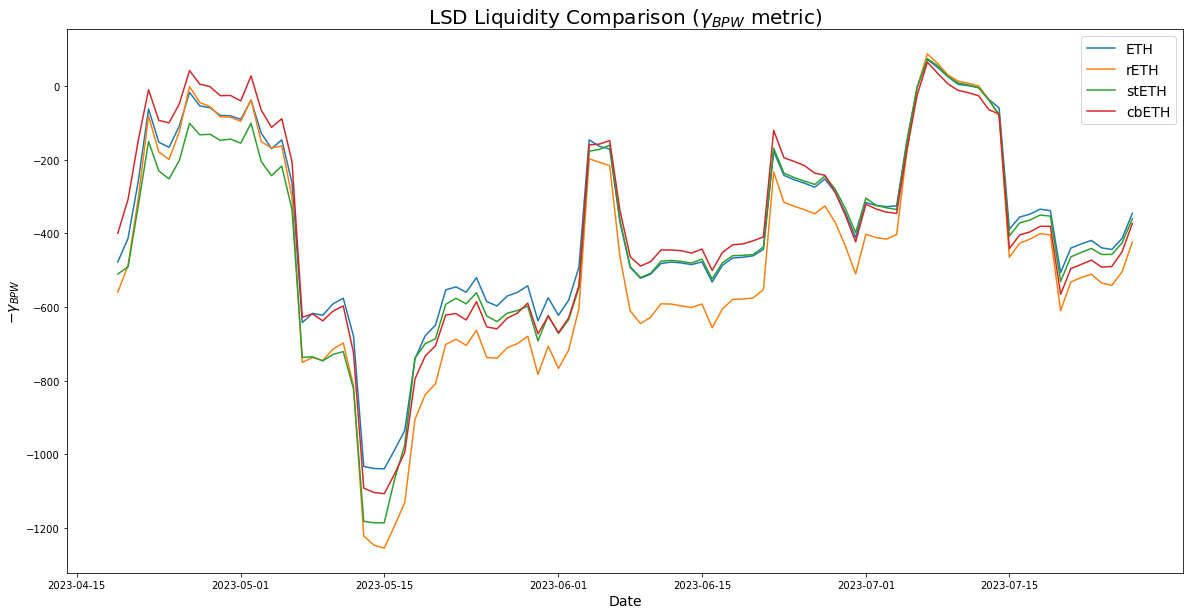

In [14]:
# plotting
plt.figure(figsize=(20, 10))
range = 100
plt.plot(ETH.index[-range:], -ETH['BPW'][-range:], label='ETH')
plt.plot(rETH.index[-range:], -rETH['BPW'][-range:], label='rETH')
plt.plot(stETH.index[-range:], -stETH['BPW'][-range:], label='stETH')
plt.plot(cbETH.index[-range:], -cbETH['BPW'][-range:], label='cbETH')

plt.title(r'LSD Liquidity Comparison ($\gamma_{BPW}$ metric)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel(r'$-\gamma_{BPW}$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

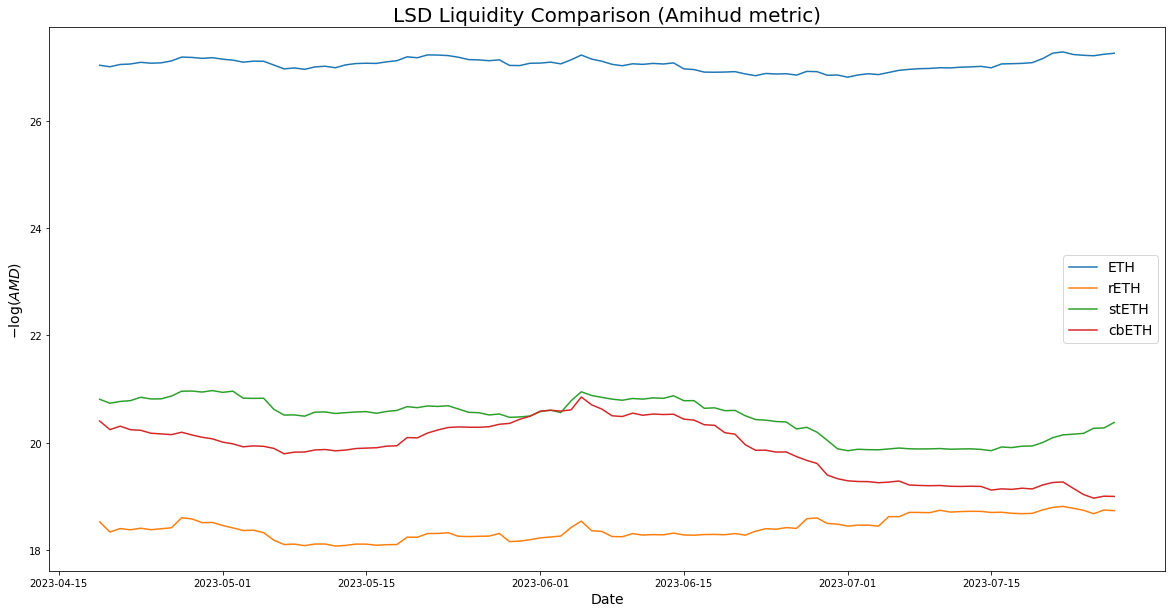

In [13]:
# plotting
plt.figure(figsize=(20, 10))
range = 100
plt.plot(ETH.index[-range:], -ETH['Amihud_log'][-range:], label='ETH')
plt.plot(rETH.index[-range:], -rETH['Amihud_log'][-range:], label='rETH')
plt.plot(stETH.index[-range:], -stETH['Amihud_log'][-range:], label='stETH')
plt.plot(cbETH.index[-range:], -cbETH['Amihud_log'][-range:], label='cbETH')

plt.title(r'LSD Liquidity Comparison (Amihud metric)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel(r'$-\log(AMD)$', fontsize=14)
plt.legend(fontsize=14)
plt.show()